<a href="https://colab.research.google.com/github/MingSheng92/AE_denoise/blob/master/DL_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!git clone https://github.com/MingSheng92/AE_denoise.git

fatal: destination path 'AE_denoise' already exists and is not an empty directory.


In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%load /content/AE_denoise/scripts/utility.py

from AE_denoise.scripts.utility import load_data, faceGrid, ResultGrid, subsample, AddNoiseToMatrix, noisy

import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
img_data, label, img_size = load_data('/content/drive/My Drive/FaceDataset/CroppedYaleB', 0)

In [64]:
img_size

(168, 168)

In [65]:
x_train, x_test, y_train, y_test = train_test_split(img_data.T, label, test_size=0.1, random_state=111)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=111)

print("Total number of training samples: ", x_train.shape)
print("Total number of training samples: ", x_val.shape)
print("Total number of validation samples: ", x_test.shape)

Total number of training samples:  (1962, 28224)
Total number of training samples:  (218, 28224)
Total number of validation samples:  (243, 28224)


In [0]:
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

#x_train = x_train.reshape(-1, img_size[0], img_size[1], 1)
#x_val = x_val.reshape(-1, img_size[0], img_size[1], 1)
x_train = np.reshape(x_train, (len(x_train), img_size[0], img_size[1], 1))  # adapt this if using `channels_first` image data format
x_val = np.reshape(x_val, (len(x_val), img_size[0], img_size[1], 1))
x_test = np.reshape(x_test, (len(x_test), img_size[0], img_size[1], 1))  # adapt this if using `channels_first` image data format

In [0]:
# add noise to the face images
noise_factor = 0.35
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

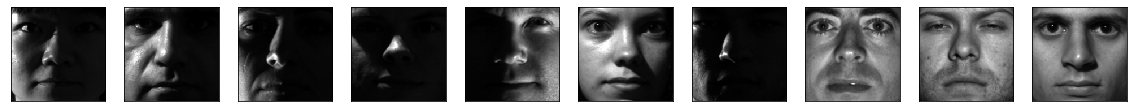

In [68]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train[i].reshape(img_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

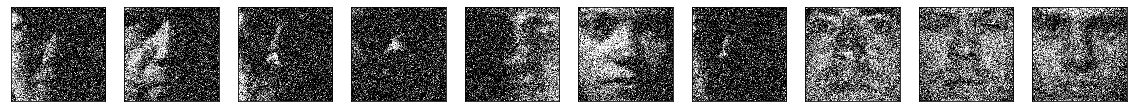

In [69]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train_noisy[i].reshape(img_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Adadelta
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

input_img = Input(shape=(168, 168, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (23, 23, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Adadelta
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K

def PSNRLoss(y_true, y_pred):
    """
    PSNR is Peek Signal to Noise Ratio, which is similar to mean squared error.
    It can be calculated as
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
    When providing an unscaled input, MAXp = 255. Therefore 20 * log10(255)== 48.1308036087.
    However, since we are scaling our input, MAXp = 1. Therefore 20 * log10(1) = 0.
    Thus we remove that component completely and only compute the remaining MSE component.
    """
    return -10. * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.)

input_layer = Input(shape=(168, 168, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization(input_shape=(168, 168, 1))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization(input_shape=(168, 168, 1))(x)

x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization(input_shape=(168, 168, 1))(x)

output = Conv2D(1, (3, 3), padding='same')(x)

autoencoder = Model(input_layer, output)
adam = Adam(lr=1e-3)
autoencoder.compile(optimizer=adam, loss='mse', metrics=[PSNRLoss])

In [72]:
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 168, 168, 1)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 168, 168, 32)      320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 168, 168, 32)      9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 168, 168, 32)      128       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 168, 168, 32)      9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 168, 168, 32)      128       
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 168, 168, 32)      9248

In [74]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=15,
                batch_size=64,
                validation_data=(x_val_noisy, x_val))

Train on 1962 samples, validate on 218 samples
Epoch 1/15
1962/1962 [==============================] - 5s 2ms/step - loss: 0.0154 - PSNRLoss: 18.1937 - val_loss: 0.0371 - val_PSNRLoss: 14.3125
Epoch 2/15
1962/1962 [==============================] - 5s 2ms/step - loss: 0.0094 - PSNRLoss: 20.3122 - val_loss: 0.0306 - val_PSNRLoss: 15.1414
Epoch 3/15
1962/1962 [==============================] - 5s 2ms/step - loss: 0.0083 - PSNRLoss: 20.8962 - val_loss: 0.0299 - val_PSNRLoss: 15.2498
Epoch 4/15
1962/1962 [==============================] - 5s 2ms/step - loss: 0.0079 - PSNRLoss: 21.1070 - val_loss: 0.0202 - val_PSNRLoss: 16.9411
Epoch 5/15
1962/1962 [==============================] - 5s 2ms/step - loss: 0.0058 - PSNRLoss: 22.4030 - val_loss: 0.0088 - val_PSNRLoss: 20.5521
Epoch 6/15
1962/1962 [==============================] - 5s 2ms/step - loss: 0.0050 - PSNRLoss: 23.0392 - val_loss: 0.0184 - val_PSNRLoss: 17.3474
Epoch 7/15
1962/1962 [==============================] - 5s 2ms/step - loss: 0

In [0]:
denoise_prediction = autoencoder.predict(x_test_noisy)

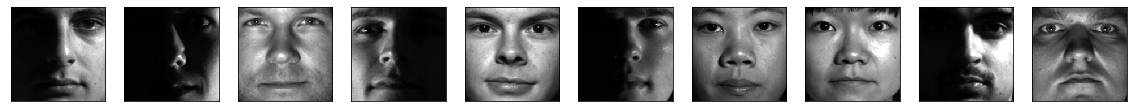

In [79]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(img_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

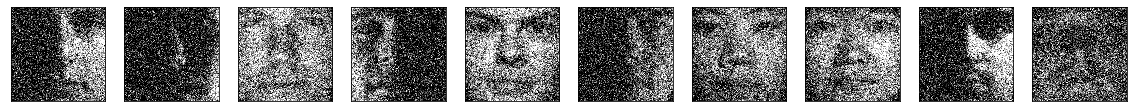

In [80]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(img_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

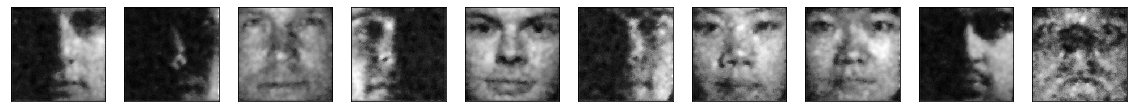

In [78]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(denoise_prediction[i].reshape(img_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()